In [1]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC

# Dataset

We import the dataset from Hastie & Tibshirani book.
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [2]:
X,y = sklearn.datasets.make_hastie_10_2()


# Creazione del dataset di esempio
# Il dataset 'make_hastie_10_2()' è comunemente usato per testare metodi di boosting.
# Contiene 10 feature per campione e una variabile target binaria (-1, +1).

# Suddivisione in training set (8000 campioni) e test set (restanti campioni)
X_train = X[:8000, :]  # Dati di addestramento
y_train = y[:8000]  # Etichette di addestramento
X_test = X[8000:, :]  # Dati di test
y_test = y[8000:]  # Etichette di tes

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [3]:
class AdaBoost:
  def __init__(self, weakModel, T):
    self.T = T
    self.weakModel = weakModel
    self.classifiers = []
    self.alphas = []
    self.wl_errors = []
    self.ens_errors = []

  def trainWeakClassifier(self, X, y, w):
    result = deepcopy(self.weakModel)
    result.fit(X,y,sample_weight=w)
    return result

  def weightedError(self, y, y_, w):
    return np.sum(w[y != y_])

  def fit(self, X, y, print_step=10):
    n = len(X)
    w = np.ones(n) / n

    ensemble_predictions = np.zeros(n)

    for t in range(self.T):
      mt = self.trainWeakClassifier(X,y,w)
      y_ = mt.predict(X)
      et = self.weightedError(y, y_, w)

      if et >= 0.5:
        raise ValueError("The weak learner error is not less than 0.5")

      at = 0.5 * math.log((1-et)/et)

      self.classifiers.append(mt)
      self.alphas.append(at)

      w = w * np.exp(- at * y * y_)
      w = w / np.sum(w)

      ensemble_predictions += at * y_
      ensemble_error = np.sum(np.sign(ensemble_predictions) != y) / n

      self.wl_errors.append(et)
      self.ens_errors.append(ensemble_error)

      if t > 1 and t % print_step == 0:
        print(f"step: {t} et: {et:.3f} ensemble error:{ensemble_error:.3f}")

    return self

  def predict(self, X):
      predictions = np.array([cl.predict(X) for cl in self.classifiers])
      return np.sign(np.array(self.alphas).dot(predictions))

# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [4]:
class SVC_:
  def __init__(self, kernel="rbf", degree="3"):
      self.svc = SVC(kernel=kernel, degree=degree)

  def fit(self, X,y,sample_weight=None):
      if sample_weight is not None:
          sample_weight = sample_weight * len(X)

      self.svc.fit(X,y,sample_weight=sample_weight)
      return self

  def predict(self, X):
      return self.svc.predict(X)

In [5]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 30)

adaboost.fit(X,y,print_step=1)

y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)

step: 2 et: 0.389 ensemble error:0.285
step: 3 et: 0.420 ensemble error:0.285
step: 4 et: 0.381 ensemble error:0.232
step: 5 et: 0.422 ensemble error:0.232
step: 6 et: 0.382 ensemble error:0.252
step: 7 et: 0.424 ensemble error:0.208
step: 8 et: 0.388 ensemble error:0.254
step: 9 et: 0.430 ensemble error:0.200
step: 10 et: 0.388 ensemble error:0.228
step: 11 et: 0.435 ensemble error:0.217
step: 12 et: 0.386 ensemble error:0.204
step: 13 et: 0.431 ensemble error:0.204
step: 14 et: 0.396 ensemble error:0.191
step: 15 et: 0.439 ensemble error:0.191
step: 16 et: 0.401 ensemble error:0.193
step: 17 et: 0.445 ensemble error:0.181
step: 18 et: 0.401 ensemble error:0.195
step: 19 et: 0.446 ensemble error:0.183
step: 20 et: 0.400 ensemble error:0.184
step: 21 et: 0.445 ensemble error:0.178
step: 22 et: 0.410 ensemble error:0.174
step: 23 et: 0.457 ensemble error:0.174
step: 24 et: 0.417 ensemble error:0.173
step: 25 et: 0.461 ensemble error:0.167
step: 26 et: 0.424 ensemble error:0.173
step: 27

In [6]:
print(f"test accuracy: {np.sum(y_test_ != y_test)/len(y_test)}:.3f")
print(f"train accuracy: {np.sum(y_train_ != y_train)/len(y_train)}:.3f")

test accuracy: 0.169:.3f
train accuracy: 0.163875:.3f


<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
C:\Users\loren_16pbl1h\AppData\Local\Temp\ipykernel_18764\2779225147.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(adaboost.wl_errors, label="$\epsilon_t$")


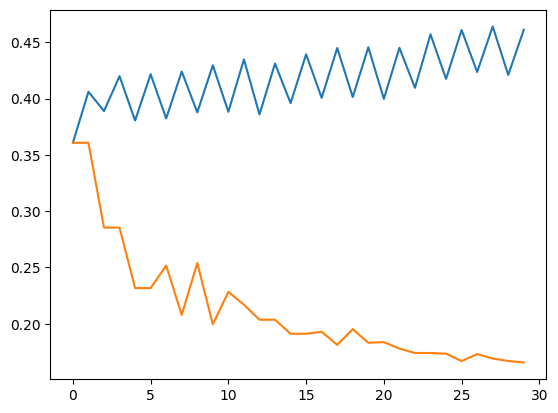

In [7]:
import matplotlib.pyplot as plt

plt.plot(adaboost.wl_errors, label="$\epsilon_t$")
plt.plot(adaboost.ens_errors, label="EnsError")

# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [8]:
class RandomLinearModel:
    def loss(self, y, y_, w):
      return np.sum(w[y != y_])

    def fit(self,X,y,sample_weight=None):
      self.colWeight = (np.random.rand(X.shape[1])-0.5) * 2
      y_ = self.predict(X)

      if self.loss(y, y_, sample_weight) >= 0.5:
        self.colWeight = - self.colWeight

      return self


    def predict(self,X):
        return np.sign(X @ self.colWeight)

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [9]:
rs = RandomLinearModel()
a = AdaBoost(rs,30000)
a.fit(X_train,y_train,print_step=100)

step: 100 et: 0.499 ensemble error:0.458
step: 200 et: 0.499 ensemble error:0.455
step: 300 et: 0.497 ensemble error:0.446
step: 400 et: 0.497 ensemble error:0.432
step: 500 et: 0.498 ensemble error:0.424
step: 600 et: 0.495 ensemble error:0.414
step: 700 et: 0.497 ensemble error:0.415
step: 800 et: 0.493 ensemble error:0.405
step: 900 et: 0.494 ensemble error:0.402
step: 1000 et: 0.496 ensemble error:0.391
step: 1100 et: 0.494 ensemble error:0.386
step: 1200 et: 0.499 ensemble error:0.383
step: 1300 et: 0.498 ensemble error:0.382
step: 1400 et: 0.499 ensemble error:0.374
step: 1500 et: 0.499 ensemble error:0.368
step: 1600 et: 0.498 ensemble error:0.370
step: 1700 et: 0.497 ensemble error:0.361
step: 1800 et: 0.493 ensemble error:0.363
step: 1900 et: 0.500 ensemble error:0.360
step: 2000 et: 0.499 ensemble error:0.361
step: 2100 et: 0.494 ensemble error:0.353
step: 2200 et: 0.499 ensemble error:0.346
step: 2300 et: 0.493 ensemble error:0.349
step: 2400 et: 0.496 ensemble error:0.345
s

In [10]:
y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

In [11]:
np.sum(y_train_ != y_train)/len(y_train)

np.float64(0.03275)

In [12]:
np.sum(y_test_ != y_test)/len(y_test)

np.float64(0.49175)

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\loren_16pbl1h\AppData\Local\Temp\ipykernel_18764\3595132436.py:1: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(a.wl_errors, label="$\epsilon_t$")


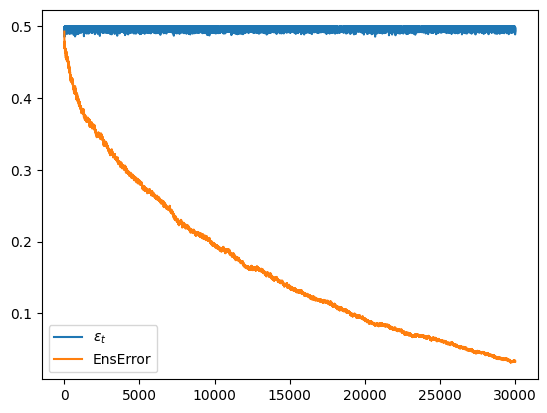

In [13]:
plt.plot(a.wl_errors, label="$\epsilon_t$")
plt.plot(a.ens_errors, label="EnsError")
plt.legend()